# Лекция 7. Модели обучения без учителя

# Кластеризация

**Задача:** разделить набор объектов одного типа на группы так, чтобы объекты в этих группах имели похожие свойства.
*“Похожесть”* формализуется с абстрактной мерой.

$D$ — набор данных, состоящий из объектов из $X.$

$\rho :X × X \rightarrow [0; +\infty)$ — метрика на $X$.

Найти алгоритм $a: X \rightarrow Y,$ где $Y$ — множество кластеров.

### Задачи

* Уменьшить объем данных
* Найти группы похожих объектов
* Найти необычные объекты
* Найти иерархию объектов

### Проблемы

* Нет правильной постановки задачи
* Нет универсального критерия качества
* Нет универсальной меры расстояния между объектами (следствие теоремы Клейнберга)
* Количество кластеров обычно неизвестно

# Алгоритмы

* **эвристические**
* эволюционные

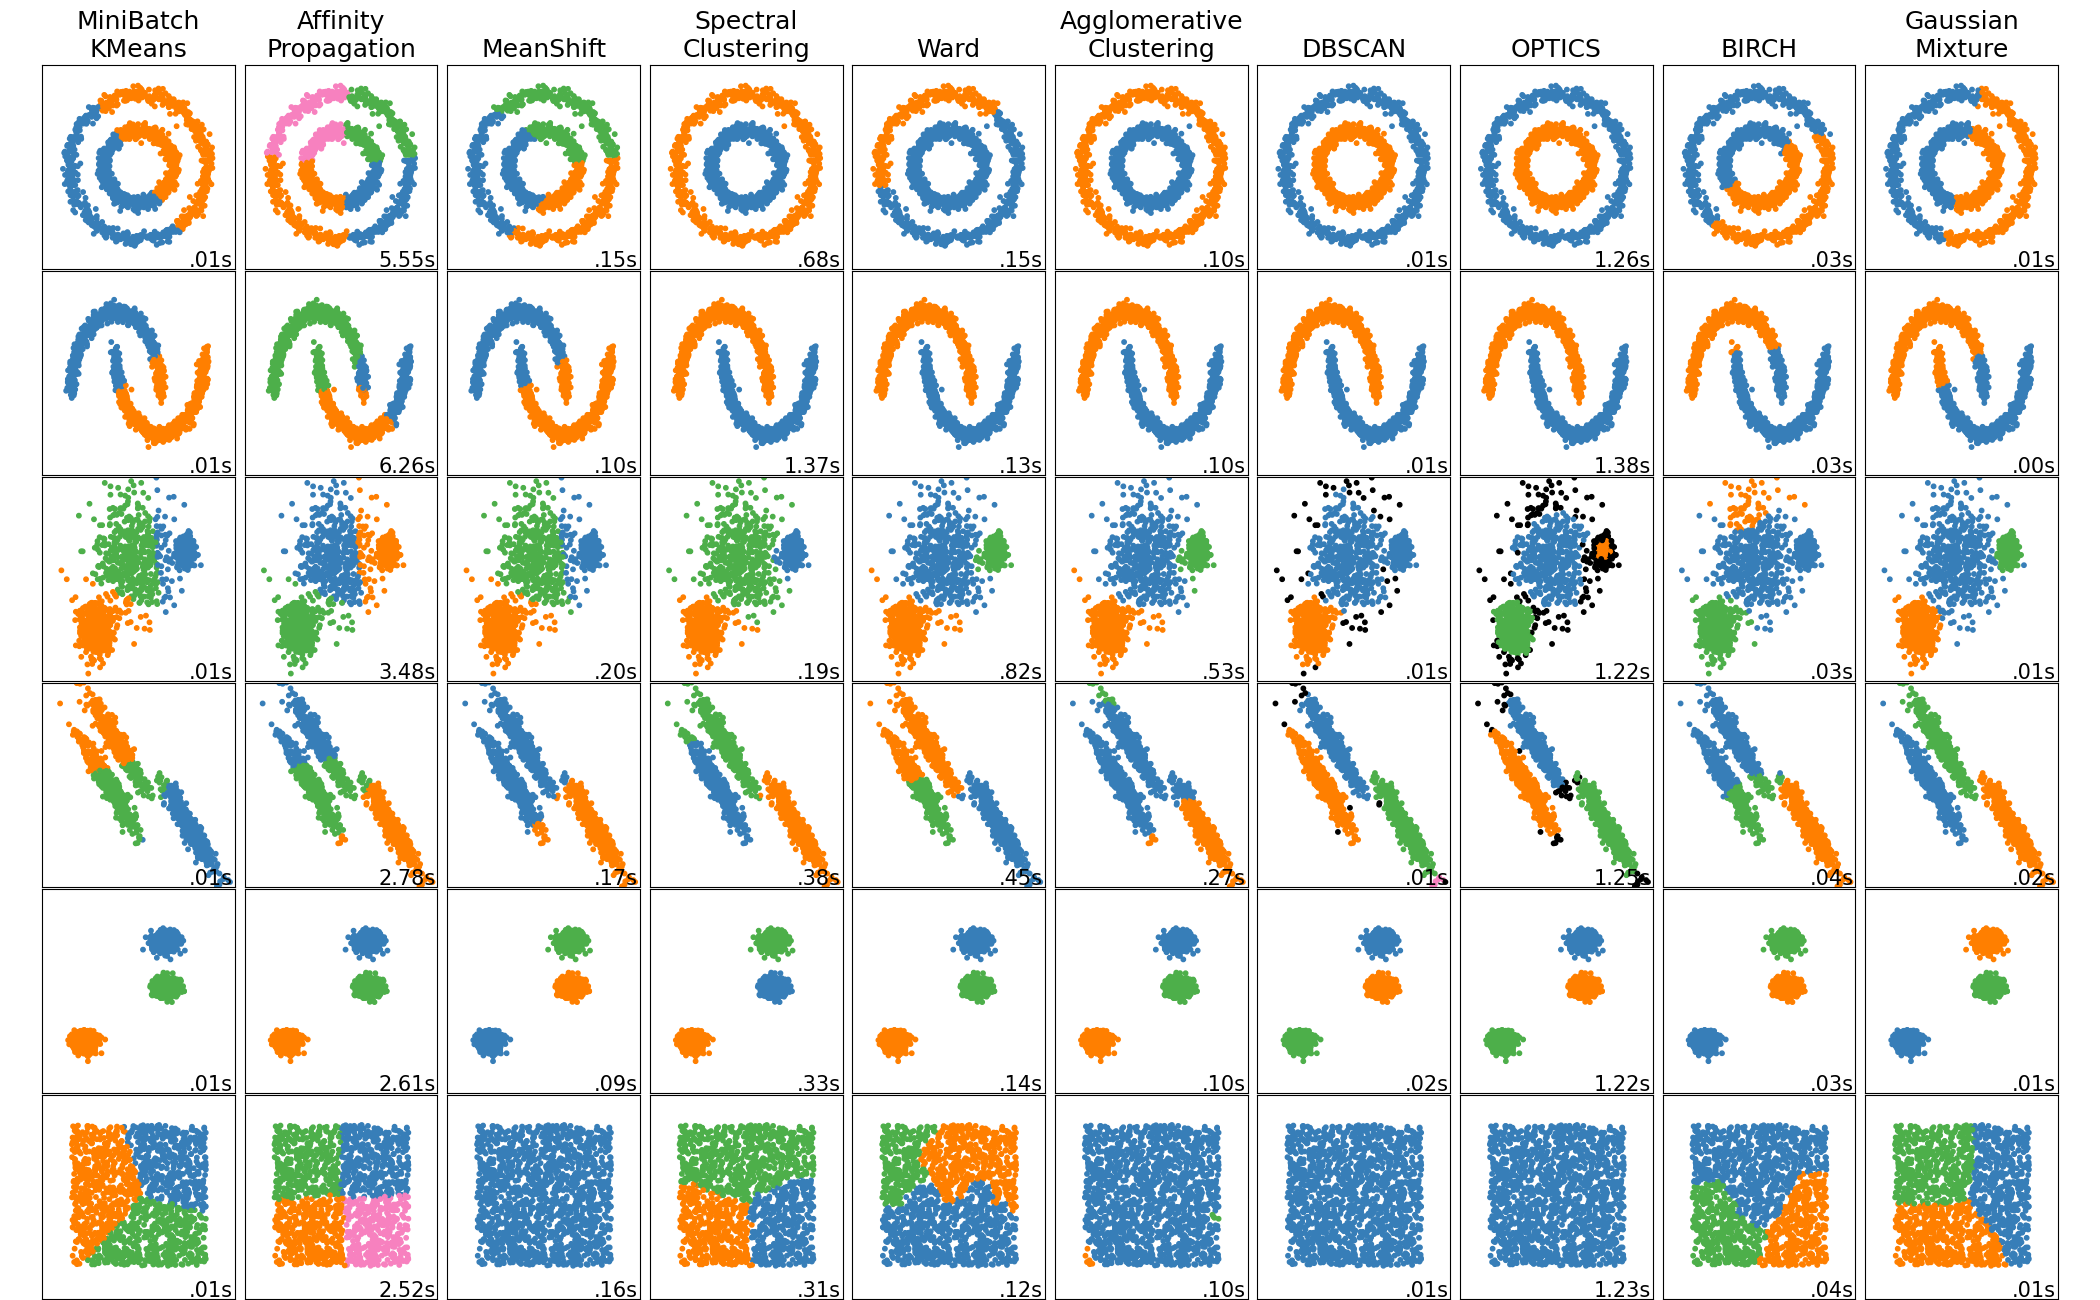

In [1]:
from IPython.display import Image
Image('./clustering_algorithms.png')

# Пример алгоритма k-средних

1. Выбрать $k$ точек (центроидов) $\{c_i\}_{i=1}^k$ из набора данных.
2. **Повторять**
    + Для каждого 𝑥 найти ближайший центроид $n(x).$ 
$$C_i = {x | n(x)=c_i}$$              
    + Для каждого $C_i$ найти центральную точку и определить её центроидом. 
3. **Пока** центроиды не будут изменяться.


In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # for plot styling
import numpy as np

Text(0.98, 0.98, 'Final Clustering')

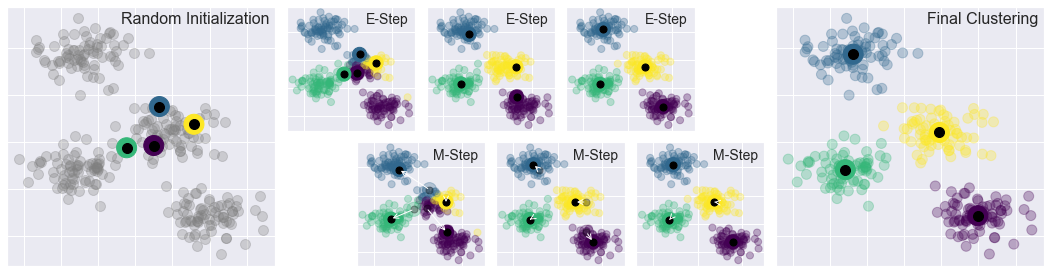

In [3]:
from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances_argmin

X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)

rng = np.random.RandomState(42)
centers = [0, 4] + rng.randn(4, 2)

def draw_points(ax, c, factor=1):
    ax.scatter(X[:, 0], X[:, 1], c=c, cmap='viridis',
               s=50 * factor, alpha=0.3)
    
def draw_centers(ax, centers, factor=1, alpha=1.0):
    ax.scatter(centers[:, 0], centers[:, 1],
               c=np.arange(4), cmap='viridis', s=200 * factor,
               alpha=alpha)
    ax.scatter(centers[:, 0], centers[:, 1],
               c='black', s=50 * factor, alpha=alpha)

def make_ax(fig, gs):
    ax = fig.add_subplot(gs)
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    return ax

fig = plt.figure(figsize=(15, 4))
gs = plt.GridSpec(4, 15, left=0.02, right=0.98, bottom=0.05, top=0.95, wspace=0.2, hspace=0.2)
ax0 = make_ax(fig, gs[:4, :4])
ax0.text(0.98, 0.98, "Random Initialization", transform=ax0.transAxes,
         ha='right', va='top', size=16)
draw_points(ax0, 'gray', factor=2)
draw_centers(ax0, centers, factor=2)

for i in range(3):
    ax1 = make_ax(fig, gs[:2, 4 + 2 * i:6 + 2 * i])
    ax2 = make_ax(fig, gs[2:, 5 + 2 * i:7 + 2 * i])
    
    # E-step
    y_pred = pairwise_distances_argmin(X, centers)
    draw_points(ax1, y_pred)
    draw_centers(ax1, centers)
    
    # M-step
    new_centers = np.array([X[y_pred == i].mean(0) for i in range(4)])
    draw_points(ax2, y_pred)
    draw_centers(ax2, centers, alpha=0.3)
    draw_centers(ax2, new_centers)
    for i in range(4):
        ax2.annotate('', new_centers[i], centers[i],
                     arrowprops=dict(arrowstyle='->', linewidth=1))
        
    
    # Finish iteration
    centers = new_centers
    ax1.text(0.95, 0.95, "E-Step", transform=ax1.transAxes, ha='right', va='top', size=14)
    ax2.text(0.95, 0.95, "M-Step", transform=ax2.transAxes, ha='right', va='top', size=14)


# Final E-step    
y_pred = pairwise_distances_argmin(X, centers)
axf = make_ax(fig, gs[:4, -4:])
draw_points(axf, y_pred, factor=2)
draw_centers(axf, centers, factor=2)
axf.text(0.98, 0.98, "Final Clustering", transform=axf.transAxes,
         ha='right', va='top', size=16)


In [4]:
from ipywidgets import interact
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import make_blobs

def plot_kmeans_interactive(min_clusters=3, max_clusters=6):
    X, y = make_blobs(n_samples=300, centers=4,
                      random_state=0, cluster_std=0.60)
        
    def plot_points(X, labels, n_clusters):
        plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis',
                    vmin=0, vmax=n_clusters - 1);
            
    def plot_centers(centers):
        plt.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c=np.arange(centers.shape[0]),
                    s=200, cmap='viridis')
        plt.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c='black', s=50)
            

    def _kmeans_step(frame=0, n_clusters=4):
        rng = np.random.RandomState(2)
        labels = np.zeros(X.shape[0])
        centers = rng.randn(n_clusters, 2)

        nsteps = frame // 3

        for i in range(nsteps + 1):
            old_centers = centers
            if i < nsteps or frame % 3 > 0:
                labels = pairwise_distances_argmin(X, centers)

            if i < nsteps or frame % 3 > 1:
                centers = np.array([X[labels == j].mean(0)
                                    for j in range(n_clusters)])
                nans = np.isnan(centers)
                centers[nans] = old_centers[nans]

        # plot the data and cluster centers
        plot_points(X, labels, n_clusters)
        plot_centers(old_centers)

        # plot new centers if third frame
        if frame % 3 == 2:
            for i in range(n_clusters):
                plt.annotate('', centers[i], old_centers[i], 
                             arrowprops=dict(arrowstyle='->', linewidth=1))
            plot_centers(centers)

        plt.xlim(-4, 4)
        plt.ylim(-2, 10)

        if frame % 3 == 1:
            plt.text(3.8, 9.5, "1. Reassign points to nearest centroid",
                     ha='right', va='top', size=14)
        elif frame % 3 == 2:
            plt.text(3.8, 9.5, "2. Update centroids to cluster means",
                     ha='right', va='top', size=14)
    
    return interact(_kmeans_step, frame=list(range(0, 50)),
                    n_clusters=[min_clusters, max_clusters])

plot_kmeans_interactive();

interactive(children=(Dropdown(description='frame', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

Далее пример иллюстрирует ситуации, когда алгоритм k-средних будут создавать неинтуитивные и, возможно, неожиданные кластеры. На первых трех графиках входные данные не соответствуют некоторому неявному предположению, которое создает k-среднее, и в результате возникают нежелательные кластеры. На последнем графике k-means возвращает интуитивно понятные кластеры, несмотря на кластеры распределёнными неравномерного с точки зрения размера.

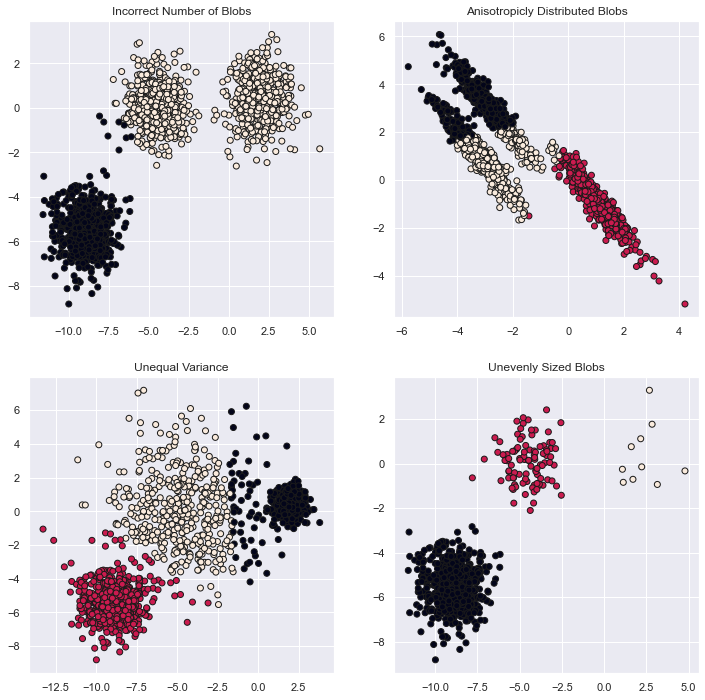

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

plt.figure(figsize=(12, 12))

n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

# Incorrect number of clusters
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X)

plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred, edgecolor='k')
plt.title("Incorrect Number of Blobs")

# Anisotropicly distributed data
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_aniso)

plt.subplot(222)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred, edgecolor='k')
plt.title("Anisotropicly Distributed Blobs")

# Different variance
X_varied, y_varied = make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_varied)

plt.subplot(223)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred, edgecolor='k')
plt.title("Unequal Variance")

# Unevenly sized blobs
X_filtered = np.vstack((X[y == 0][:500], X[y == 1][:100], X[y == 2][:10]))
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_filtered)

#colors = np.random.rand(len())
plt.subplot(224)
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred, edgecolor='k')
plt.title("Unevenly Sized Blobs")

plt.show()

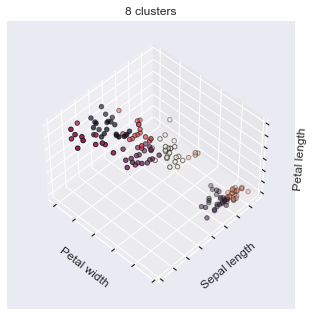

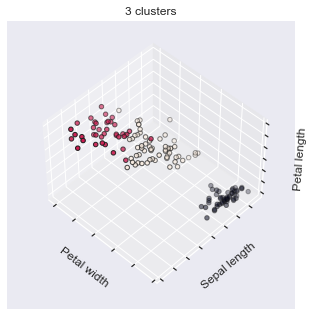

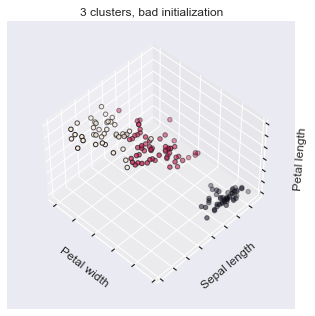

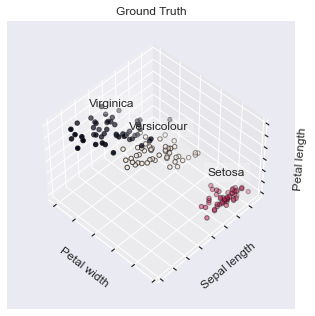

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Though the following import is not directly being used, it is required
# for 3D projection to work
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn import datasets

np.random.seed(5)

iris = datasets.load_iris()
X = iris.data
y = iris.target

estimators = [
    ("k_means_iris_8", KMeans(n_clusters=8)),
    ("k_means_iris_3", KMeans(n_clusters=3)),
    ("k_means_iris_bad_init", KMeans(n_clusters=3, n_init=1, init="random")),
]

fignum = 1
titles = ["8 clusters", "3 clusters", "3 clusters, bad initialization"]
for name, est in estimators:
    fig = plt.figure(fignum, figsize=(5, 4))
    ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
    est.fit(X)
    labels = est.labels_

    ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=labels.astype(float), edgecolor="k")

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel("Petal width")
    ax.set_ylabel("Sepal length")
    ax.set_zlabel("Petal length")
    ax.set_title(titles[fignum - 1])
    ax.dist = 12
    fignum = fignum + 1

# Plot the ground truth
fig = plt.figure(fignum, figsize=(5, 4))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)

for name, label in [("Setosa", 0), ("Versicolour", 1), ("Virginica", 2)]:
    ax.text3D(
        X[y == label, 3].mean(),
        X[y == label, 0].mean(),
        X[y == label, 2].mean() + 2,
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.2, edgecolor="w", facecolor="w"),
    )
# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 2, 0]).astype(float)
ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=y, edgecolor="k")

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel("Petal width")
ax.set_ylabel("Sepal length")
ax.set_zlabel("Petal length")
ax.set_title("Ground Truth")
ax.dist = 12

fig.show()

# Метрики оценки качества кластеризации

Несмотря на то, что универсальной меры качества выявить невозможно, существует два типа численных мер:
* **внешние** — меры основаны на сравнении результата кластеризации с априори известным разделением на классы.
* **внутренние** — меры отображают качество кластеризации только по информации в данных.

[Подробная статья на викиконспектах](http://neerc.ifmo.ru/wiki/index.php?title=%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0_%D0%B2_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B5_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8#.D0.9C.D0.B5.D1.82.D0.BE.D0.B4.D1.8B_.D0.BE.D1.86.D0.B5.D0.BD.D0.BA.D0.B8_.D0.BA.D0.B0.D1.87.D0.B5.D1.81.D1.82.D0.B2.D0.B0_.D0.BA.D0.BB.D0.B0.D1.81.D1.82.D0.B5.D1.80.D0.B8.D0.B7.D0.B0.D1.86.D0.B8.D0.B8)

# Cнижение размерности

Объекты описаны признаками $F =(f_1,…,f_n).$

**Задача:** построить множество признаков $G=(g_1,…,g_k): k < n$ (часто $k << n$), при переход к которым сопровождается наименьшей потерей информации.

Зачем это нужно?
* Ускорение обучение и обработку
* Борьба с шумом и мультиколлинеарностью
* Интерпретация и визуализация данных

**Проклятие размерности (curse of dimensionality)** — это набор проблем, возникающих с ростом размерности
* Увеличиваются требования к памяти и вычислительной мощности
* Данные становятся более разреженными
* Проще найти гипотезы, не имеющие отношения к реальности

**Уменьшение размерности** — шаг в предобработки данных.
* Меньше памяти для хранения
* Уменьшение времени обработки
* Увеличение качества обработки 
* Понимание природы признаков

## Два способа уменьшения размерности:
### Выбор признаков (Feature selection)
Включает методы, для которых $G \subset F.$
Они
* быстро работают;
* не могут «выдумывать» сложных признаков.

Цели выбора признаков:
* Уменьшение переобучения у улучшение качества предсказания
* Улучшее понимание моделей

**Типы признаков с точки зрения уменьшения размерности:**
* Избыточные (redundant) — признаки не привносят дополнительной информации относительно существующих
* Нерелевантные (irrelevant) — признаки просто неинформативны

### Извлечение признаков (Feature extraction)
Включает все другие методы (в том числе даже те, у которых $k > n$).
* в целом, дольше работают;
* могут извлекать сложные признаки. 

Цель методов извлечения признаков:
* Уменьшение числа ресурсов, требуемых для обработки больших данных
* Поиск новых признаков
* Эти признаки могут быть линейными и нелинейными относительно исходных

## Алгоритмы извлечения признаков

### PCA

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

Populating the interactive namespace from numpy and matplotlib


#### Теория

Рассмотрим двухмерный пример, где вместо двух признаков можно завести их линейную комбинацию.

Для "хорошего" направления сумма расстояний до выбранной прямой (гиперплоскости) минимальна. Слева показано "хорошее" навправление, справа - "плохое".

<img src='pca_good_bad_direction.png'>

Пусть прямая задается единичным вектором $u$. Минимизация расстояния от точки $x^{(i)}$ до прямой эквивалентна минимизации угла между радиус-вектором $x^{(i)}$ и вектором $u$. Косинус такого угла можно выразить так:

$$ \Large cos~\theta = \frac{x^{{(i)}^T} u }{||x^{(i)}||}, ||u|| = 1$$

Задача состоит в том, чтобы найти такое направление $u$, что сумма квадратов проекций минимальна (то есть сумма квадратов косинусов максимальна). 

$$\Large u = \arg\max_{||u||=1} \frac{1}{m} \sum_{i=1}^{m} {(x^{{(i)}^T} u )^2} = \arg\max_{||u||=1} \frac{1}{m} \sum_{i=1}^{m} {(u^Tx^{{(i)}} )(x^{{(i)}^T} u )} =$$ $$ \Large  \arg\max_{||u||=1} u^T \left[\frac{1}{m} \sum_{i=1}^{m}{x^{(i)} x^{(i)^T}} \right] u $$

Удобно ввести ковариационную матрицу $$\Large \Sigma = \sum_{i=1}^{m}{x^{(i)} x^{(i)^T}} = X^TX \in \mathbb{R}^{n \times n}$$

Тогда решается оптимизационная задача:

$$\Large \max_{u}{u^T \Sigma u},~~~u^Tu = 1$$

Лагранжиан для этой задачи: $$\Large L(u, \lambda) = u^T \Sigma u - \lambda (u^Tu-1)$$

Его производная по $u$: $$\Large \nabla_u L = \Sigma u - \lambda u = 0 \Leftrightarrow \Sigma u =\lambda u$$

То есть $u$ должен быть собственным вектором ковариационной матрицы $\Sigma$.

Обобщение: если хотим ввести $k$-размерное пространства вместо $n$- размерного, берем $k$ собственных векторов ковариационной матрицы $\Sigma$, соответсвующих $k$ максимальным собственным значениям. Тогда новым образом каждой точки $x^{(i)} \in \mathbb{R}^n$ обучающей выборки будет 
$$\Large z^{(i)} = \left[
\begin{array}{c}
u_1^Tx^{(i)} \\ 
u_2^Tx^{(i)} \\ 
\ldots \\ 
u_k^Tx^{(i)} 
\end{array}
\right] \in \mathbb{R}^k$$

Один из наиболее эффективных способов нахождения собственных векторов матрицы $\Sigma$ - импользование сингулярного разложения исходной матрицы $X$:

$$\Large X = UDV^T,$$

где $U \in R^{m \times m}$,  $V \in R^{n \times n}$, а $D \in R^{m \times n}$ - диагональная матрица вида

<img src='svd_diag_matrix.png' width=50%>

#### Сингулярное разложение

Рассмотрим более подробно задачу о сингулярном разложении матрицы $X \in \mathbb{R}^{m \times n}$. 
*Сингулярным разложением* матрицы $X$ называется представление её в виде $X = UD V^T$, где:

 - $D$ есть $m\times n$ матрица у которой элементы, лежащие на главной диагонали, неотрицательны, а все остальные элементы равны нулю.
 - $U$ и $V$ - ортогональные матрицы порядка $m$  и $n$ соответственно.
 
Элементы главной диагонали матрицы $D$ называются *сингулярными числами* матрицы $X$, а столбцы $U$ и $V$ левыми и правыми *сингулярными векторами* матрицы $X$.

Заметим, что матрицы $XX^T$ и $X^TX$ являются симметрическими неотрицательно определенными матрицами, и поэтому ортогональным преобразованием могут быть приведены к диагональному виду, причем на диагонали будут стоять неотрицательные собственные значения этих матриц.

В силу указанных выше свойств матриц $X^TX$ и $XX^T$ сингулярное разложение матрицы $X$ тесно связано с задачей о спектральном разложении этих матриц. Более точно:
- Левые сингулярные векторы матрицы $X$ - это собственные векторы матрицы $XX^T$.
- Правые сингулярные векторы матрицы $X$ - это собственные векторы матрицы $X^TX$.
- Сингулярные числа матрицы $X$ - это корни из собственных значений матрицы $X^TX$ (или $XX^T$).

Таким образом, для нахождения сингулярного разложения матрицы $X$ необходимо, найти собственные векторы и значения матриц $X^TX$ и $XX^T$ и составить из них матрицы $U, V, D$.

#### Алгоритм PCA
1. Определить $k<n$ - новую размерность
2. Вычесть из $X$ среднее, то есть заменить все $\Large x^{(i)}$  на $$\Large  x^{(i)} - \frac{1}{m} \sum_{i=1}^{m}{x^{(i)}}$$
3. Привести данные к единичной дисперсии: посчитать $$\Large  \sigma_j^2 = \frac{1}{m} \sum_{i=1}^{m}{(x^{(i)})^2}$$
и заменить $\Large x_j^{(i)}$ на $\Large \frac{x_j^{(i)}}{\sigma_j}$ 
4. Найти сингулярное разложение матрицы $X$:
$$\Large X = UDV^T$$
5. Положить $V =$ [$k$ левых столбцов матрицы $V$]
6. Вернуть новую матрицу $$\Large Z = XV \in \mathbb{R}^{m \times k}$$

Proportion of variance explained by each component:
1st component - 0.94,
2nd component - 0.06

Directions of principal components:
1st component: [-0.57532172  0.81792721] 
2nd component: [-0.81792721 -0.57532172]


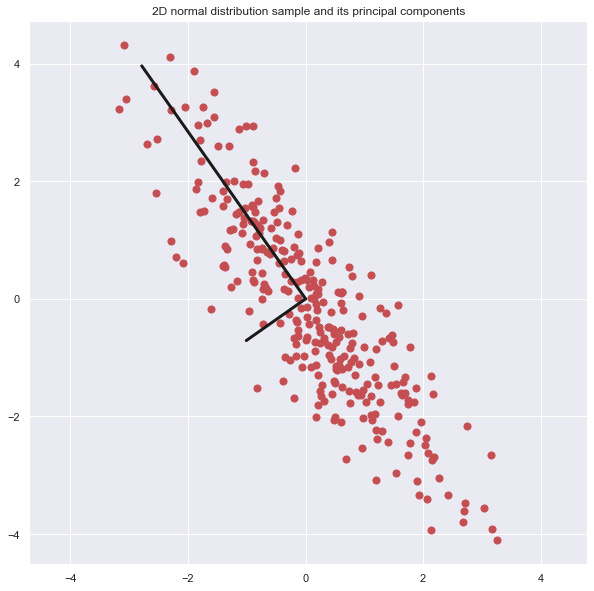

In [8]:
np.random.seed(0)
mean = np.array([0.0, 0.0])
cov = np.array([[1.0, -1.0], 
                [-2.0, 3.0]])
X = np.random.multivariate_normal(mean, cov, 300)

pca = PCA()
pca.fit(X)
print('Proportion of variance explained by each component:\n' +\
      '1st component - %.2f,\n2nd component - %.2f\n' %
      tuple(pca.explained_variance_ratio_))
print('Directions of principal components:\n' +\
      '1st component:', pca.components_[0],
      '\n2nd component:', pca.components_[1])

plt.figure(figsize=(10,10))
plt.scatter(X[:, 0], X[:, 1], s=50, c='r')
for l, v in zip(pca.explained_variance_ratio_, pca.components_):
    d = 5 * np.sqrt(l) * v
    plt.plot([0, d[0]], [0, d[1]], '-k', lw=3)
plt.axis('equal')
plt.title('2D normal distribution sample and its principal components')
plt.show()

Первая главная компонента (ей соответствует более длинный вектор) объясняет более 90% дисперсии исходных данных. Это говорит о том, что она содержит в себе почти всю информацию о расположении выборки в пространстве, и вторая компонента может быть опущена. Спроецируем данные на нёё.

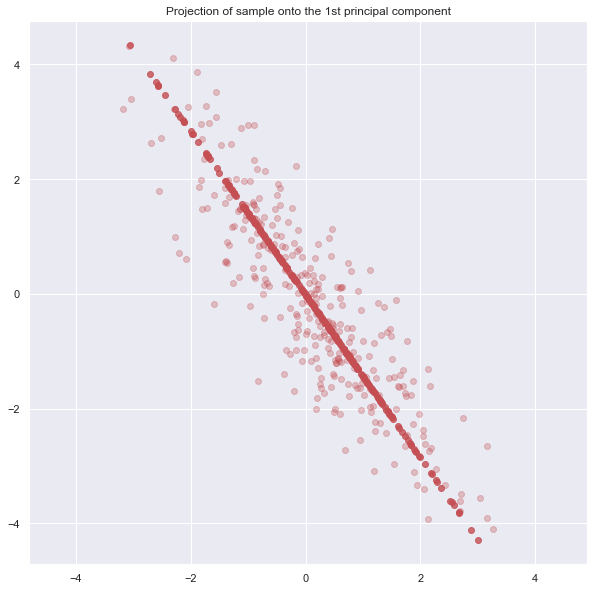

In [9]:
# Keep enough components to explain 90% of variance
pca = PCA(0.90)
X_reduced = pca.fit_transform(X)

# Map the reduced data into the initial feature space
X_new = pca.inverse_transform(X_reduced)

plt.figure(figsize=(10,10))
plt.plot(X[:, 0], X[:, 1], 'or', alpha=0.3)
plt.plot(X_new[:, 0], X_new[:, 1], 'or', alpha=0.8)
plt.axis('equal')
plt.title('Projection of sample onto the 1st principal component')
plt.show()

**Пример с набором данных iris**

Meaning of the 2 components:
0.361 x sepal length (cm) + -0.085 x sepal width (cm) + 0.857 x petal length (cm) + 0.358 x petal width (cm)
0.657 x sepal length (cm) + 0.730 x sepal width (cm) + -0.173 x petal length (cm) + -0.075 x petal width (cm)


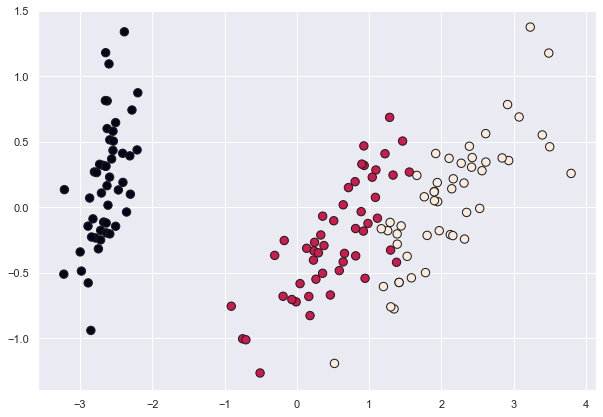

In [10]:
from sklearn import datasets

iris = datasets.load_iris()
X, y = iris.data, iris.target

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

print("Meaning of the 2 components:")
for component in pca.components_:
    print(" + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component,
                                            iris.feature_names)))
plt.figure(figsize=(10,7))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=70, edgecolor="k")
plt.show()

#### Пример с digits

Projecting 64-dimensional data to 2D


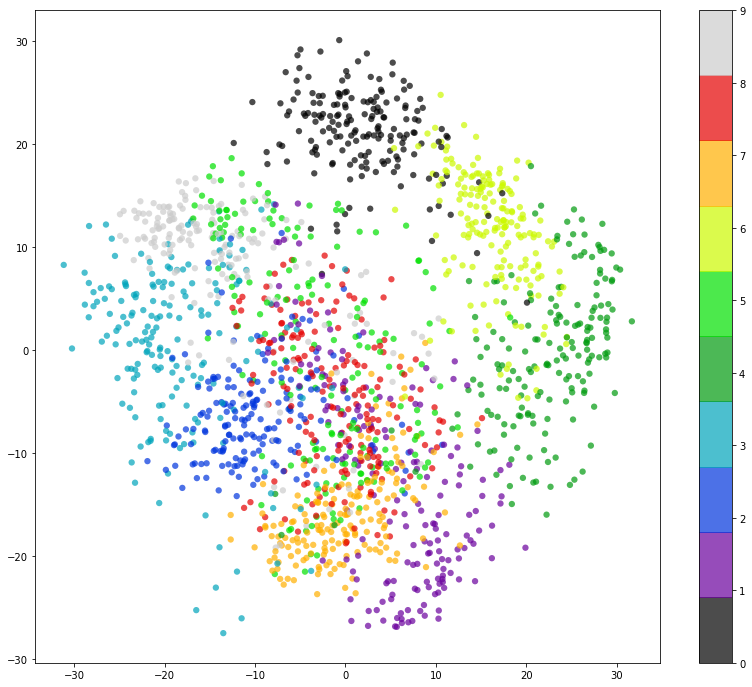

In [6]:
from sklearn.datasets import load_digits

digits = load_digits()
X = digits.data
y = digits.target

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

print('Projecting %d-dimensional data to 2D' % X.shape[1])

plt.figure(figsize=(14,12))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.show()

Полученная картинка позволяет увидеть зависимости между различными цифрами. Например, цифры 0 и 6 располагаются в соседних кластерах, что говорит об их схожем написании. Наиболее "разбросанный" (по другим кластерам) - это кластер, соответствующий цифре 8, что говорит о том, что она имеет много различных написаний, делающих её схожей со многими другими цифрами.

### TSNE

**Стохастическое вложение соседей с t-распределением (t-distributed stochastic neighbor embedding, t-SNE)** — это алгоритм уменьшения размерности
* Нелинейный
* Используется для визуализации
* Пытается сохранять метрические отношения между объектами

Краткий алгоритм:
* Определим вероятность для точки «выбрать ближайшим соседом» другую точку в пространстве 
* Построим такие распределения для высокоразменых и низкоразмерных представлений
* Минимизируем расстояние между двумя распределениями

Определим распределения для обоих пространств так:

$$p_{j|i}= \frac{exp⁡(−‖x_i−x_j ‖^2/2\sigma^2 )}{\sum_{k \ne j} exp⁡(−‖x_i−x_k ‖^2/2\sigma^2 )}$$

Это выражение показывает, насколько точка $x_j$ близка к $x_i$, при гауссовом распределении вокруг $x_i$ с заданной дисперсией $\sigma^2$

$$q_{j|i} = \frac{exp⁡(−‖y_i−y_j ‖^2) }{\sum_{k \ne j} exp⁡(−‖ y_i - y_k ‖^2 )}$$

Здесь мы полагаем, что стандартное отклонение предлагается установить в $\frac{1}{\sqrt 2}$

**Физическая интерпретация.** Все точки отображения соединены пружинами. Жесткость пружины, соединяющей точки $i$ и $j$ зависит от разности между сходством двух точек в многомерном пространстве и двух точек в пространстве отображения. В этой аналогии, градиент — это результирующая сила, действующая на точку в пространстве отображения. Если систему «отпустить», через какое-то время она придет в равновесие, это и будет искомое распределение. Алгоритмически, поиск равновесия предлагается делать с учетом моментов.

Определим сходство, как симметричный вариант условного сходства:
    
$$p_{ij}=\frac{p_{j|i}+p_{i|j}}{2|X|} $$

Для модифицированного пространства будем использовать распрделение Стьюдента

$$q_{ij} = \frac{(1+‖y_i−y_j ‖^2)^{-1}) }{\sum_{k \ne l} ⁡(1+‖ y_k - y_l ‖^2 )^{-1}}$$

Далее будем минимизировать сходство между распределениями посредством формулы Кульбака-Лейблера

$D_{KL} (𝑃||𝑄)=\sum_{i,j} p_{ij}  \log⁡(\frac{p(x_{ij})}{q(x_ij)}),$


#### Пример с набором данных iris

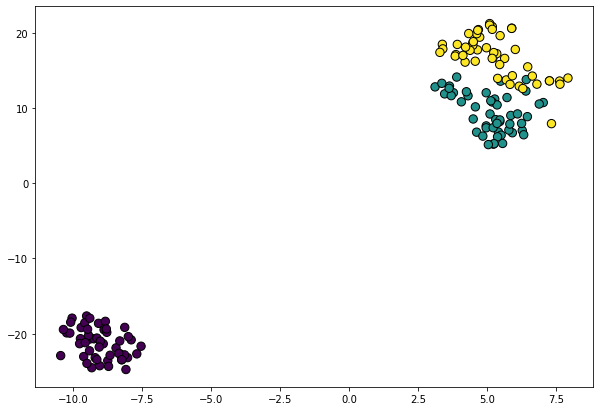

In [4]:
from sklearn import datasets
from sklearn.manifold import TSNE

iris = datasets.load_iris()
X, y = iris.data, iris.target

tsne = TSNE(n_components=2, random_state=42)

X_reduced = tsne.fit_transform(X)


plt.figure(figsize=(10,7))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=70, edgecolor="k")
plt.show()

#### Пример с digits

Projecting 64-dimensional data to 2D


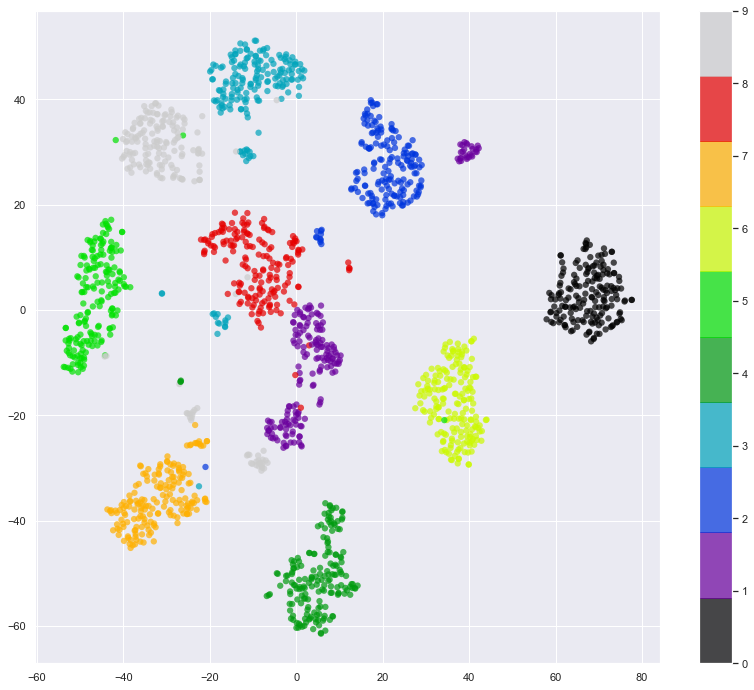

In [15]:
digits = load_digits()


X = digits.data
y = digits.target

tsne = TSNE(n_components=2, random_state=0)

X_reduced = tsne.fit_transform(X)

print('Projecting %d-dimensional data to 2D' % X.shape[1])

plt.figure(figsize=(14,12))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.show()

### UMAP

UMAP (Uniform Manifold Approximation and Projection) — это новый алгоритм уменьшения размерности, библиотека с реализацией которого вышла совсем недавно.

Поскольку для глубокого понимания принципов работы алгоритма требуется сильная математическая подготовка, знание римановой геометрии и топологии, мы опишем лишь общую идею модели UMAP, которую можно разделить на два основных шага. На первом этапе оцениваем пространство, в котором по нашему предположению и находятся данные. Его можно задать априори (как просто $R^n$), либо оценить на основе данных. А на втором шаге пытаемся создать отображение из оцененного на первом этапе пространства в новое, меньшей размерности.

**Важные параметры.**
1. *Число соседей — n_neighbors.* Варьируя этот параметр, можно выбирать, что важнее сохранить в новом пространственном представлении данных: глобальную или локальную структуру данных. Маленькие значения параметра означают, что, пытаясь оценить пространство, в котором распределены данные, алгоритм ограничивается малой окрестностью вокруг каждой точки, то есть пытается уловить локальную структуру данных (возможно в ущерб общей картине). С другой стороны большие значения n_neighbors заставляют UMAP учитывать точки в большей окрестности, сохраняя глобальную структуру данных, но упуская детали.

+ С количеством соседей, равным единице, алгоритм работает просто ужасно, поскольку слишком сильно фокусируется на деталях и попросту не может уловить общую структуру данных.
+ С ростом количества соседей модель все меньше внимания уделяет различиям между разными видами одежды, группируя похожие и смешивая их между собой. В то же время абсолютно разные предметы гардероба становятся все дальше друг от друга. Как уже было сказано, общая картина становится ясней, а детали размываются.

2. *Минимальное расстояние — min_dist.* Данный параметр стоит понимать буквально: он определяет минимальное расстояние, на котором могут находиться точки в новом пространстве. Низкие значения стоит применять в случае, если вас интересует, на какие кластеры разделяются ваши данные, а высокие — если вам важнее взглянуть на структуру данных, как единого целого. Увеличение значения параметра приводит к меньшей "степени кластеризации", данные собираются в кучу и различия между ними стираются. Интересно, что при минимальном значении min_dist алгоритм пытается найти различия внутри кластеров и разделить их на еще более мелкие группы.

**Пример с digits**

In [17]:
import umap
digits = load_digits()

X = digits.data
y = digits.target

reducer = umap.UMAP(n_neighbors=3, min_dist = 0.2, random_state=42)
reducer.fit(digits.data)

UMAP(dens_frac=0.0, dens_lambda=0.0, min_dist=0.2, n_neighbors=3,
     random_state=42)

In [18]:
X_reduced = reducer.transform(digits.data)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(X_reduced == reducer.embedding_))
X_reduced.shape

(1797, 2)

Projecting 64-dimensional data to 2D


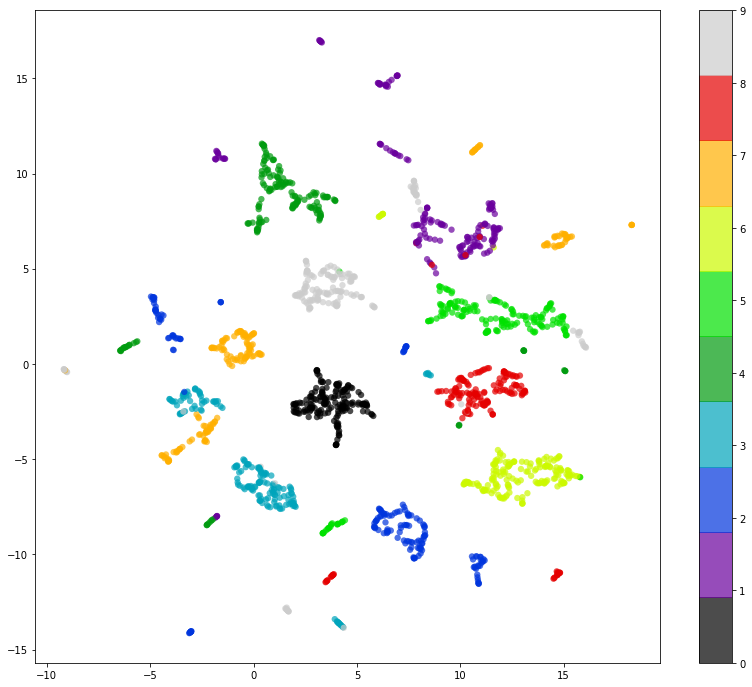

In [19]:
#plt.scatter(embedding[:, 0], embedding[:, 1], c=digits.target, cmap='Spectral', s=5)
#plt.gca().set_aspect('equal', 'datalim')
#plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
#plt.title('UMAP projection of the Digits dataset', fontsize=24);

print('Projecting %d-dimensional data to 2D' % X.shape[1])

plt.figure(figsize=(14,12))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.show()